## Chapter 1: data analysis of S&P500 daily close prices

**by Li Shen, Ph.D.**

**E-mail: shenli.sam@gmail.com**

**LinkedIn: https://www.linkedin.com/in/lshen**

**Updated: 2016/06/01**

## Summary

In this chapter, various statistical properties of the S&P500 daily close prices are explored, including stationarity, normality, linearity, heteroskedasticity and nonlinearity. The basic conclusions are: 1. the raw data are non-stationary while the log return data are stationary; 2. the log return data have fat tails and are modestly skewed; 3. the linear independency between the current log return and its lagged values cannot be rejected; 4. the log return data contain heteroskedasticity; 4. there is nonlinearity between the current log return and its lagged values.

### Load data and libraries

In [1]:
%pylab inline
import numpy as np
import pandas as pd

/Users/lishen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Load SP500 daily closing prices from Jun 1 2012 to Aug 30 2014 from Yahoo finance.

In [2]:
import pandas_datareader.data as web
from datetime import datetime
sp500_daily = web.DataReader("^GSPC", "yahoo", datetime(2012, 1, 1), datetime(2014, 8, 30))

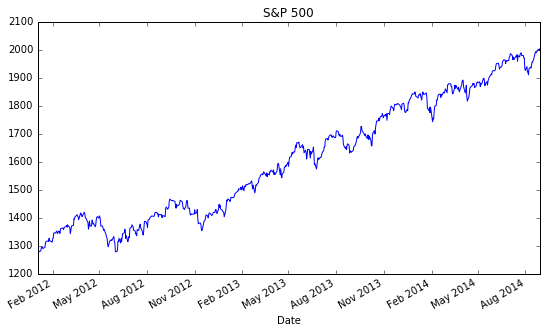

In [3]:
ts = sp500_daily['Adj Close']
ts.plot(figsize=[9, 5], title='S&P 500')

Looks like the SP500 index has been climbing steadily during this period.

The purpose of this study is to forecast the S&P500 log returns. So here I calculate the log returns and use them across the board.

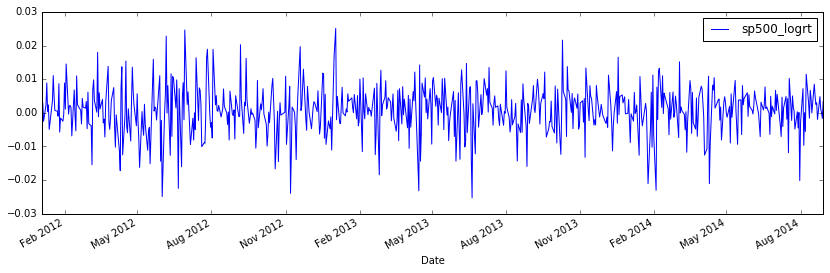

In [4]:
ts_logrt = pd.DataFrame(diff(log(ts)), index=ts.index[1:], columns=['sp500_logrt'])
ts_logrt.plot(figsize=(14, 4))

Clearly, the log return data displays volatility clustering.

Save the log return data to an external file for later use.

In [5]:
ts_logrt.to_csv('ts_logrt.csv')

### 1.1 Stationarity

The stationarity of a time series can be assessed with unit root tests. Here I will use three different tests on the raw S&P500 index and its log return series. They are: Augmented Dickey-Fuller (ADF) test, Phillips-Perron (PP) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test. 

Based on the observation, there is no time trend in the log return series. There might be a small, positive drift. So I'll add a constant term to the tests.

In [6]:
from arch.unitroot import ADF, PhillipsPerron, KPSS
raw_adf = ADF(ts, trend='c')
lrt_adf = ADF(ts_logrt, trend='c')
raw_pp = PhillipsPerron(ts, trend='c')
lrt_pp = PhillipsPerron(ts_logrt, trend='c')
raw_kpss = KPSS(ts, trend='c')
lrt_kpss = KPSS(ts_logrt, trend='c')

In [7]:
# Fortmat the statistics and p-values for output.
ars = "%.2f" % (raw_adf.stat)
arp = "%.2E" % (raw_adf.pvalue)
als = "%.2f" % (lrt_adf.stat)
alp = "%.2E" % (lrt_adf.pvalue)
##
prs = "%2f" % (raw_pp.stat)
prp = "%.2E" % (raw_pp.pvalue)
pls = "%.2f" % (lrt_pp.stat)
plp = "%.2E" % (lrt_pp.pvalue)
##
krs = "%.2f" % (raw_kpss.stat)
krp = "%.2E" % (raw_kpss.pvalue)
kls = "%.2f" % (lrt_kpss.stat)
klp = "%.2E" % (lrt_kpss.pvalue)

Summarize the three tests on the two series in the following:

Test|Null hypothesis|Raw|Log return
----|---------------|---|----------
ADF|Nonstationary|{{ars}}, {{arp}}|{{als}}, {{alp}}
PP|Nonstationary|{{prs}}, {{prp}}|{{pls}}, {{plp}}
KPSS|Weakly stationary|{{krs}}, {{krp}}|{{kls}}, {{klp}}

It can be seen that all three tests and in consistency and the conclusion is that the raw index series is nonstationary while the log return series is stationary.

### 1.2 Normality

The Jarque-Bera (JB) test is often used to test the normality of a sample. Here I'll use it to test the normality of the log return series.

In [10]:
from statsmodels.stats.stattools import jarque_bera
lrt_jb = jarque_bera(ts_logrt)

In [11]:
ljbs = "%.2f" % (lrt_jb[0][0])
ljbp = "%.2E" % (lrt_jb[1][0])
lsk = "%.2f" % (lrt_jb[2][0])
lku = "%.2f" % (lrt_jb[3][0])

The JB test result is summarized in the following table:

Measure|Value
-------|-----
Skewness|{{lsk}}
Kurtosis|{{lku}}
JB stat|{{ljbs}}
JB p-value|{{ljbp}}

It can be seen that the log return series is left skewed and has fat tails. The JB test clearly rejects the null hypothesis that the log return series is normally distributed.

To gain some visual intuition of the data, I also use the Q-Q plot to compare the data with the normal distribution using the sample mean and sample standard deviation as parameters.

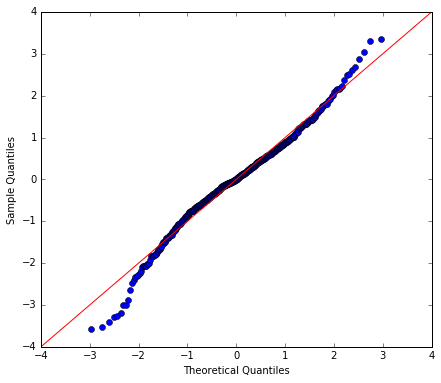

In [12]:
from statsmodels.graphics.gofplots import qqplot
fig, ax = subplots()
fig.set_size_inches([7, 6])
_ = qqplot(ts_logrt.values.ravel(), line='45', fit=True, ax=ax)

The Q-Q plot seems to correspond with the JB test result very well: at both lower and upper quantiles, the data deviates from the normal distribution; the deviation seems to be more significant at the lower quantiles than at the upper quantiles, indicating the data is left skewed.

### 1.3 Linearity

Here I set out to test the linear independency of the log return series with its own lagged values. I'll perform the tests on both the log return series and the residuals from ARMA model fit.

In [10]:
# Split the log return series into in- and out-samples. 
split_date = '2014-06-01'
lrt_train = ts_logrt[:split_date]
lrt_test = ts_logrt[split_date:]
print lrt_train.shape
print lrt_test.shape

(604, 1)
(64, 1)


In [14]:
# Use Durbin-Watson (DW) test for 1st order auto-correlation.
from statsmodels.stats.stattools import durbin_watson
lrt_train_dw = durbin_watson(lrt_train)
print "log return train set DW stat=", lrt_train_dw

log return train set DW stat= [ 2.00151186]


In [15]:
# Use Ljung-Box (LB) test for auto-correlation when jointly considering multiple lags.
from statsmodels.stats.diagnostic import acorr_ljungbox
lrt_train_lb = acorr_ljungbox(lrt_train, lags=20)
lrt_lb_res = pd.DataFrame(np.c_[lrt_train_lb[0], lrt_train_lb[1]], 
                          index=range(1, len(lrt_train_lb[0]) + 1), 
                          columns=['Stat', 'P-value'])
lrt_lb_res.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Stat,0.050098,0.457473,0.929459,5.781416,8.860682,9.049722,9.392680,11.176169,11.204326,13.360146,13.404334,13.777648,15.198880,16.724875,17.483062,17.725107,18.435015,18.506471,19.347962,19.366765
P-value,0.822893,0.795538,0.818313,0.216078,0.114752,0.170801,0.225679,0.191916,0.261963,0.204227,0.267722,0.315132,0.295102,0.271136,0.290816,0.340238,0.361908,0.422786,0.434727,0.498114


Both DW and LB tests show that we cannot reject the null hypothesis of the linear independency of the log return series with its own lagged values. Although there might still be nonlinearity in the series.

However, I'll still build an ARMA model for the log return series. This serves several purposes:
* To confirm the linear independency of the series with its own lagged values.
* To create a baseline model for performance comparison with other machine learning methods.
* To use the residuals from the ARMA model fit for additional tests and model building.

#### 1.3.1 Automatic ARMA model selection

The *statsmodels* package contains a convenient function to automatically select the (p, q) order of an ARMA model. Using a high order can be computationally expensive. What's more, the above tests have already shown that there is no auto-correlation at higher orders. Therefore, I will set the maximum order at 5 for both AR and MA terms here.

In [16]:
from  statsmodels.tsa.stattools import arma_order_select_ic
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    arma_modsel_res = arma_order_select_ic(lrt_train, max_ar=5, max_ma=5, 
                                           ic='aic', trend='c')

In [17]:
print 'Selected model (p, q) order based on AIC=', arma_modsel_res['aic_min_order']

Selected model (p, q) order based on AIC= (1, 1)


In [13]:
from statsmodels.tsa.arima_model import ARIMA
# However, using order of (1, 1) generates the error that 
# AR coefficients are not stationary. Change the order to
# (2, 1) solved the problem. The reason behind this awaits
# further exploration.
lrt_arma_mod = ARIMA(lrt_train, [2, 0, 1])
lrt_arma_res = lrt_arma_mod.fit(trend='c')
print(lrt_arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:            sp500_logrt   No. Observations:                  604
Model:                     ARMA(2, 1)   Log Likelihood                2107.090
Method:                       css-mle   S.D. of innovations              0.007
Date:                Wed, 01 Jun 2016   AIC                          -4204.179
Time:                        14:30:47   BIC                          -4182.161
Sample:                    01-04-2012   HQIC                         -4195.610
                         - 05-30-2014                                         
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                 0.0007   4.35e-05     15.409      0.000         0.001     0.001
ar.L1.sp500_logrt     0.9718      0.041     23.893      0.000         0.892     1.052
ar.L2.sp500_logrt    -0.

/Users/lishen/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


It can be seen that the AR(2) term has a non-significant coefficient. However, adding this term induces stationarity in model fitting. All of the constant, AR(1) and MA(1) coefficients show high statistical significance. Both AR(1) and MA(1) terms seem to have large coefficients. However, since AR and MA terms cancel out each other, the overall effect is very small.

In [14]:
# I set up an ARMA model on the whole dataset so that the 
# prediction can take advantage of the info from the train
# set.
lrt_arma_tot = ARIMA(ts_logrt, [2, 0, 1])
# The following fit call merely serves the purpose of setting up
# parameters. I do not intend to fit an ARMA model on the whole 
# dataset because the parameters will be provided by the train 
# model.
_ = lrt_arma_tot.fit(trend='c', maxiter=0, disp=-1)
# Let the prediction start from the end of the train set, or the
# begin of the test set.
arma_test_pred = lrt_arma_tot.predict(lrt_arma_res.params, len(lrt_train))

/Users/lishen/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
arma_train_pred = lrt_arma_res.fittedvalues.values.ravel()
#np.save('arma_train_pred.npy', arma_train_pred)
#np.save('arma_test_pred.npy', arma_test_pred)

In [17]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
print '== ARMA performance on log returns: =='
print 'Train R2=', r2_score(lrt_train, arma_train_pred)
print 'Test R2=', r2_score(lrt_test, arma_test_pred)

== ARMA performance on log returns: ==
Train R2= 0.014360780874
Test R2= 0.023732207651


Extract the residuals for further uses.

In [22]:
arma_train_resid = lrt_train.values.ravel() - arma_train_pred
arma_test_resid = lrt_test.values.ravel() - arma_test_pred
arma_all_resid = concatenate((arma_train_resid, arma_test_resid))
np.save('arma_train_resid.npy', arma_train_resid)
np.save('arma_test_resid.npy', arma_test_resid)

Use Ljung-Box (LB) test on train residuals and add Breush-Godfrey LM test on the residuals too.

In [34]:
from statsmodels.stats.diagnostic import acorr_breush_godfrey
resid_train_lb = acorr_ljungbox(arma_train_resid, lags=20)
resid_train_lm = np.array(map(lambda lags: acorr_breush_godfrey(lrt_arma_res, lags), 
                              range(1, 21)))
resid_train_acorr = pd.DataFrame(np.c_[np.array(lrt_train_lb).T, 
                                       np.array(resid_train_lb).T, 
                                       resid_train_lm[:, :2]], 
                                 index=range(1, 21), 
                                 columns=['lrt.LB.s', 'lrt.LB.p', 
                                          'resid.LB.s', 'resid.LB.p', 
                                          'resid.LM.s', 'resid.LM.p'])

In [35]:
resid_train_acorr

,lrt.LB.s,lrt.LB.p,resid.LB.s,resid.LB.p,resid.LM.s,resid.LM.p
1,0.050098,0.822893,0.000045,0.994659,-0.000596,1.000000
2,0.457473,0.795538,0.047158,0.976697,0.042128,0.979156
3,0.929459,0.818313,0.117339,0.989678,0.110623,0.990533
4,5.781416,0.216078,3.252699,0.516461,3.234889,0.519314
5,8.860682,0.114752,5.077955,0.406441,5.062277,0.408327
6,9.049722,0.170801,5.710771,0.456357,5.629846,0.465904
7,9.392680,0.225679,5.773232,0.566464,5.722648,0.572482
8,11.176169,0.191916,8.489588,0.387162,7.984356,0.435000
9,11.204326,0.261963,8.709878,0.464474,8.071177,0.526989
10,13.360146,0.204227,11.801521,0.298560,11.378950,0.328766


It can be seen that after ARMA model fit, the auto-correlation is further removed from the series comparing the two LB test results. And LM test result confirms that the auto-correlation is non-existent.

### 1.4 Heteroskedasticity

As shown above, the log return series displays volatility clustering. Conditional heteroskedasticity is a common phenomenon in financial time series, which is the source of the data's non-normality. First, I'll test its existence using the LB test on the squared residuals from ARMA fit.

In [36]:
res2_train_lb = acorr_ljungbox(arma_train_resid**2, lags=20)
res2_lb_res = pd.DataFrame(np.c_[res2_train_lb[0], res2_train_lb[1]], 
                           index=range(1, len(res2_train_lb[0]) + 1), 
                           columns=['Stat', 'P-value'])
res2_lb_res.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Stat,0.423911,4.897765,11.136899,12.084088,13.341097,18.796596,20.387216,22.677118,23.646928,24.070912,24.318019,25.170548,25.516556,29.830875,31.282968,31.980564,32.279801,33.215442,33.275173,33.827716
P-value,0.514992,0.086390,0.011008,0.016737,0.020384,0.004521,0.004791,0.003804,0.004896,0.007414,0.011457,0.014035,0.019726,0.008052,0.008050,0.010058,0.013887,0.015716,0.022341,0.027314


Except lag=1 and 2, the result at all other lags rejects the null hypothesis that there is no auto-correlation in the squared residuals at the significance level of 0.05, indicating the existence of conditional heteroskedasticity.

**NOT DONE: Other tests for heteroskedasticity:**

from `lmtest`:

"the Breusch-Pagan test fits a linear regression model to the residuals and rejects if too much of the variance is explained by the auxiliary explanatory variables, which are here the squared lagged values.

Whereas the Breusch-Pagan test and the Harrison-McCabe test do not assume a particular timing of the change of variance, the Goldfeld-Quandt test suffers from the same problem as the Chow test for a change of the regression coefficients: the breakpoint has to be known in advance."

#### 1.4.1 GARCH(1, 1) model

In [37]:
from arch.univariate import arch_model
arma_resid_am = arch_model(arma_train_resid**2, mean='Zero', 
                           vol='Garch', p=1, q=1)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    arma_resid_am_res = arma_resid_am.fit(update_freq=0, disp='off', cov_type='robust')
arma_resid_am_res.summary()

/Users/lishen/anaconda/lib/python2.7/site-packages/arch/univariate/base.py:519: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                4657.57
Distribution:                  Normal   AIC:                          -9309.15
Method:            Maximum Likelihood   BIC:                          -9295.93
                                        No. Observations:                  604
Date:                Mon, May 23 2016   Df Residuals:                      601
Time:                        12:33:18   Df Model:                            3
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      1.2290e-09  1.963e-08  6.261e-02      0.950  [-3.725e-08,3.970e-08]
alpha[1]       0.1000      0.111      0.900      0.368       [ -0.118,  0.318]
beta[1]        0.8000  8.837e-02      9.053  1.396e-19       [  0.627,  0.973]
==============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate sucessful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

Despite the warning about the convergence, the GARCH(1,1) model fit indicates a strong effect of the 1st order auto-regressive term. 

**TODO**: redo LB and maybe LM tests on the GARCH residuals. The *arch* package does not provide a function to retrieve GARCH residuals: the member *resid* contains the residuals of the mean model.

### 1.5 Nonlinearity

#### 1.5.1 BDS test

In [38]:
from rpy2.robjects.packages import importr
tseries = importr('tseries')

In [39]:
from rpy2 import robjects
r_arma_resid = robjects.FloatVector(arma_train_resid)
bds_res = tseries.bds_test(r_arma_resid, m=5)

In [40]:
print bds_res.rx('statistic')
print bds_res.rx('p.value')
#print bds_res.rx('parameter')

$statistic
  0.00369808198178155 0.0073961639635631 0.0110942459453446 0.0147923279271262
2            2.069490           1.882686           1.038981          0.3660474
3            2.815996           2.971127           2.114720          1.3172180
4            4.150430           4.020788           3.181360          2.2605676
5            4.280081           4.766198           3.864152          2.8400090


$p.value
  0.00369808198178155 0.0073961639635631 0.0110942459453446 0.0147923279271262
2        3.850017e-02       5.974300e-02       0.2988134891        0.714329718
3        4.862631e-03       2.967094e-03       0.0344538373        0.187765546
4        3.318516e-05       5.800375e-05       0.0014658523        0.023786049
5        1.868249e-05       1.877350e-06       0.0001114756        0.004511226




Clearly, the BDS test rejects the null hypothesis that the residuals are i.i.d. and there are nonlinear structures remaining in the residuals of the ARMA fit. However, the BDS test does not tell us what sort of nonlinearity is there.

#### 1.5.2 Harvey-Collier test

In [41]:
from statsmodels.stats.diagnostic import linear_harvey_collier
hctest_res = linear_harvey_collier(lrt_arma_res)
print 'Statistic: %.2f, P-value: %.2f' % (hctest_res.statistic, hctest_res.pvalue)

Statistic: -0.23, P-value: 0.82


Harvey-Collier test does not reject its null hypothesis, which means the nonlinearity is not convex (or concave).

#### 1.5.3 Teraesvirta Neural Network Test

In [42]:
stats = importr('stats')
rts_lrt_train = stats.as_ts(robjects.FloatVector(lrt_train.values.ravel()))
lag_list = [1, 2, 5, 10, 15, 20]
ttype_list = ['Chisq', 'F']
tera_res = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.terasvirta_test(rts_lrt_train, lag=lag, type=ttype)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        tera_res.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)

In [43]:
tera_res

,1,2,5,10,15,20
Chisq,"0.45, 7.98E-01","9.22, 2.37E-01","74.16, 1.49E-02","516.98, 0.00E+00","inf, 0.00E+00","inf, 0.00E+00"
F,"0.22, 7.99E-01","1.31, 2.44E-01","1.43, 3.07E-02","1.57, 5.19E-05","-inf, NAN","-inf, NAN"


The Teraesvirta NN test suggests that at large lag size (>=5), the linearity hypothesis can be rejected and there exists nonlinearity in the log return series.

#### 1.5.4 White Neural Network Test

The White NN test seems to be a fancier version of the NN test than the Teraesvirta test with extra parameters that control the # of phantom hidden units and the # of PCs. 

In [44]:
white_res = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.white_test(rts_lrt_train, lag=lag, type=ttype)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        white_res.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)
white_res

,1,2,5,10,15,20
Chisq,"0.44, 8.02E-01","0.83, 6.62E-01","2.24, 3.27E-01","8.66, 1.31E-02","0.32, 8.51E-01","0.63, 7.30E-01"
F,"0.24, 7.90E-01","0.55, 5.78E-01","0.09, 9.17E-01","1.02, 3.61E-01","0.38, 6.83E-01","0.22, 7.99E-01"


In [45]:
white_res2 = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.white_test(rts_lrt_train, lag=lag, type=ttype, q=20, qstar=4)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        white_res2.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)
white_res2

,1,2,5,10,15,20
Chisq,"0.70, 9.51E-01","1.01, 9.09E-01","8.11, 8.77E-02","6.51, 1.64E-01","2.79, 5.94E-01","3.43, 4.89E-01"
F,"0.19, 9.45E-01","0.56, 6.88E-01","1.52, 1.94E-01","0.38, 8.19E-01","0.66, 6.22E-01","0.99, 4.12E-01"


In [46]:
white_res3 = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.white_test(rts_lrt_train, lag=lag, type=ttype, q=5, qstar=2)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        white_res3.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)
white_res3

,1,2,5,10,15,20
Chisq,"0.67, 7.16E-01","0.24, 8.86E-01","7.47, 2.39E-02","0.06, 9.71E-01","1.89, 3.88E-01","2.13, 3.44E-01"
F,"0.35, 7.08E-01","0.27, 7.64E-01","0.89, 4.11E-01","0.27, 7.64E-01","1.49, 2.25E-01","0.42, 6.58E-01"


With varied # of hidden units and PCs, the null hypothesis of linearity is not rejected by the White NN test.